In [78]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score , mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns



import warnings
import numpy as np
warnings.filterwarnings('ignore')

# Load the datasets
singapore_df = pd.read_csv('datasets/singapore_listings.csv')
ny_df = pd.read_csv('datasets/newyorkcity_listings.csv')
madrid_df = pd.read_csv('datasets/madrid_listings.csv')

### Exploratory Data Analysis (EDA)

In [79]:
# Overview

# Singapore
summary = {
    "Info": singapore_df.info(),
    "Head": singapore_df.head(),
    "Describe": singapore_df.describe(),
    "Missing": singapore_df.isnull().sum(),
}
print("Singapore", summary)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7907 entries, 0 to 7906
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              7907 non-null   int64  
 1   name                            7905 non-null   object 
 2   host_id                         7907 non-null   int64  
 3   host_name                       7907 non-null   object 
 4   neighbourhood_group             7907 non-null   object 
 5   neighbourhood                   7907 non-null   object 
 6   latitude                        7907 non-null   float64
 7   longitude                       7907 non-null   float64
 8   room_type                       7907 non-null   object 
 9   price                           7907 non-null   int64  
 10  minimum_nights                  7907 non-null   int64  
 11  number_of_reviews               7907 non-null   int64  
 12  last_review                     51

In [80]:
#New York

summary = {
    "Info": ny_df.info(),
    "Head": ny_df.head(),
    "Describe": ny_df.describe(),
    "Missing": ny_df.isnull().sum(),
}

print("New York", summary)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [81]:
# Madrid

summary = {
    "Info": madrid_df.info(),
    "Head": madrid_df.head(),
    "Describe": madrid_df.describe(),
    "Missing": madrid_df.isnull().sum(),
}

print("Madrid", summary)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19618 entries, 0 to 19617
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              19618 non-null  int64  
 1   name                            19615 non-null  object 
 2   host_id                         19618 non-null  int64  
 3   host_name                       19091 non-null  object 
 4   neighbourhood_group             19618 non-null  object 
 5   neighbourhood                   19618 non-null  object 
 6   latitude                        19618 non-null  float64
 7   longitude                       19618 non-null  float64
 8   room_type                       19618 non-null  object 
 9   price                           19618 non-null  int64  
 10  minimum_nights                  19618 non-null  int64  
 11  number_of_reviews               19618 non-null  int64  
 12  last_review                     

#### Outlier Visualiazation

In [82]:
def print_outliers(df,numeric_features=None):
   
    # Define the numeric features
    if numeric_features is None:
        numeric_features = [
            'minimum_nights', 'number_of_reviews', 
            'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'price'
        ]

    if len(numeric_features)==1:
        sns.boxplot(x=df[numeric_features[0]])
        plt.title(f'Boxplot for {numeric_features[0]}')
        plt.xlabel(numeric_features[0])
        plt.show()
    else:
        # Create boxplots to visually identify outliers in each numeric feature
        boxplot_figure, axes = plt.subplots(nrows=len(numeric_features), ncols=1, figsize=(8, 8))
        for i, feature in enumerate(numeric_features):
            sns.boxplot(x=df[feature], ax=axes[i])
            axes[i].set_title(f'Boxplot for {feature}')
            axes[i].set_xlabel(feature)

        # Display the boxplots
        boxplot_figure.tight_layout()
        boxplot_figure.show()

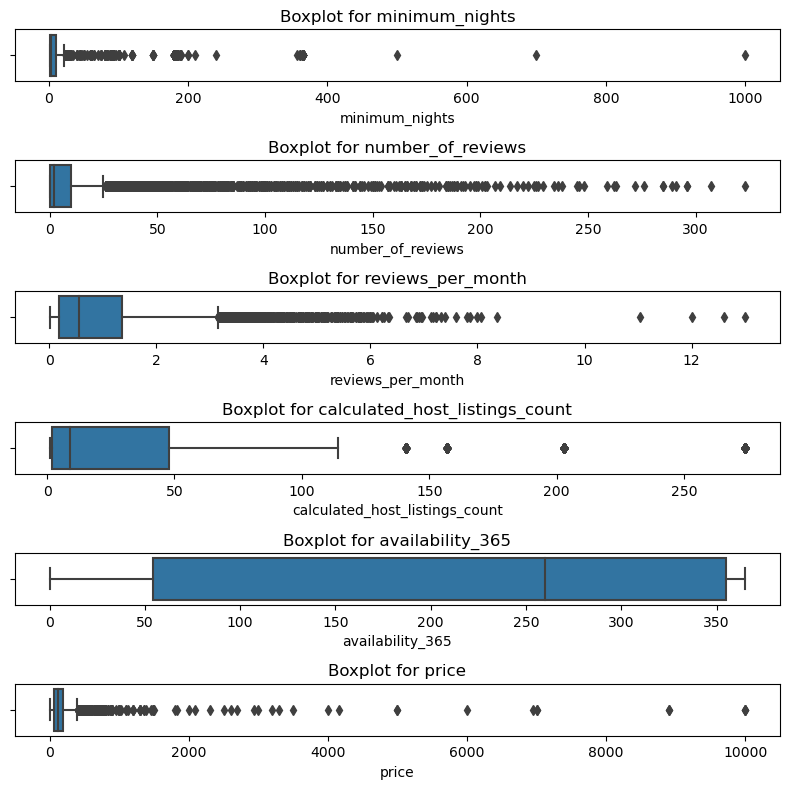

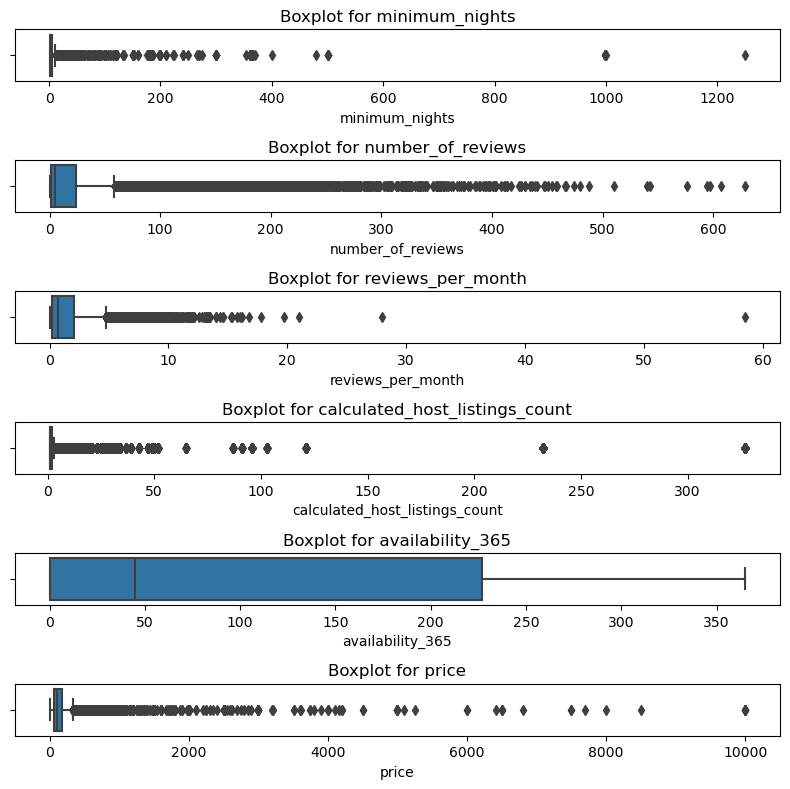

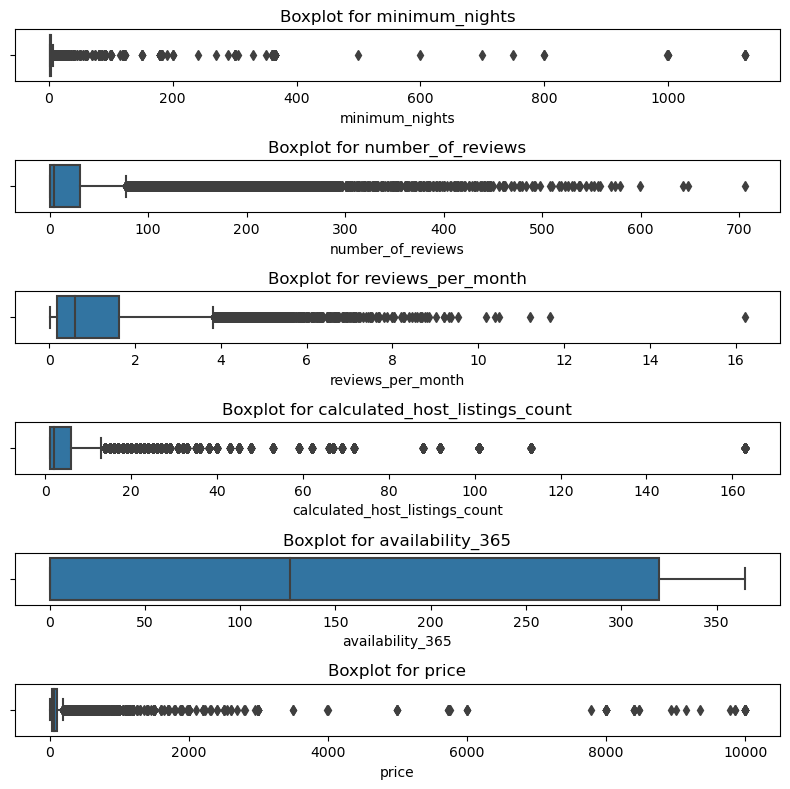

In [83]:
print_outliers(singapore_df)
print_outliers(ny_df)
print_outliers(madrid_df)

In [84]:
# Calculate metrics
def calculate_metrics(y_test, y_pred):   
    rmse = mean_squared_error(y_test, y_pred, squared=False)    
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return rmse, mae, r2


# Preprocessor
def get_preprocessor():    
    # Defining preprocessing for numeric columns
    numeric_features = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    # Defining preprocessing for categorical columns
    categorical_features = ['neighbourhood_group', 'neighbourhood', 'room_type']
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    # Combining preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)        
        ],
        remainder='drop'
    )
    
    return preprocessor       


In [85]:
# Models

# Random Forest
def random_forest_model(preprocessor):
    rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', RandomForestRegressor(random_state=42))])
    return rf_pipeline

# Linear Regression
def linear_regression_model(preprocessor):
    lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', LinearRegression())])
    return lr_pipeline

# XGBoost
def xgboost_model(preprocessor):
    xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', XGBRegressor(random_state=42))])
    return xgb_pipeline

# Model Prediction
def get_prediction(X_train, y_train, X_test, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

preprocessor = get_preprocessor()
rf_model = random_forest_model(preprocessor)
lr_model = linear_regression_model(preprocessor)
xg_model = xgboost_model(preprocessor)


### Baseline Preprocessing

In [86]:
def get_X_y(df):  
    
    X = df.drop('price', axis=1)
    y = df['price']
    return X, y

singapore_X, singapore_y = get_X_y(singapore_df)
ny_X, ny_y = get_X_y(ny_df) 
madrid_X, madrid_y = get_X_y(madrid_df)

# Split the data into training and testing sets
singapore_X_train, singapore_X_test, singapore_y_train, singapore_y_test = train_test_split(singapore_X, singapore_y, test_size=0.3, random_state=42)
ny_X_train, ny_X_test, ny_y_train, ny_y_test = train_test_split(ny_X, ny_y, test_size=0.3, random_state=42)
madrid_X_train, madrid_X_test, madrid_y_train, madrid_y_test = train_test_split(madrid_X, madrid_y, test_size=0.3, random_state=42)

In [87]:
# Metrics per city

# Singapore
singapore_rf_rmse, singapore_rf_mae, singapore_rf_r2 = calculate_metrics(singapore_y_test, get_prediction(singapore_X_train, singapore_y_train, singapore_X_test, rf_model))
singapore_lr_rmse, singapore_lr_mae, singapore_lr_r2 = calculate_metrics(singapore_y_test, get_prediction(singapore_X_train, singapore_y_train, singapore_X_test, lr_model))
singapore_xg_rmse, singapore_xg_mae, singapore_xg_r2 = calculate_metrics(singapore_y_test, get_prediction(singapore_X_train, singapore_y_train, singapore_X_test, xg_model))

print("Singapore:")
print(f"Random Forest Regressor: RSME: {singapore_rf_rmse}, MAE: {singapore_rf_mae}, R2: {singapore_rf_r2}")
print(f"Linear Regression: RSME: {singapore_lr_rmse}, MAE: {singapore_lr_mae}, R2: {singapore_lr_r2}")
print(f"XGBoost: RSME: {singapore_xg_rmse}, MAE: {singapore_xg_mae}, R2: {singapore_xg_r2}")


# NY
ny_rf_rmse, ny_rf_mae, ny_rf_r2 = calculate_metrics(ny_y_test, get_prediction(ny_X_train, ny_y_train, ny_X_test, rf_model))
ny_lr_rmse, ny_lr_mae, ny_lr_r2 = calculate_metrics(ny_y_test, get_prediction(ny_X_train, ny_y_train, ny_X_test, lr_model))
ny_xg_rmse, ny_xg_mae, ny_xg_r2 = calculate_metrics(ny_y_test, get_prediction(ny_X_train, ny_y_train, ny_X_test, xg_model))

print("\nNY:")
print(f"Random Forest Regressor: RSME: {ny_rf_rmse}, MAE: {ny_rf_mae}, R2: {ny_rf_r2}")
print(f"Linear Regression: RSME: {ny_lr_rmse}, MAE: {ny_lr_mae}, R2: {ny_lr_r2}")
print(f"XGBoost: RSME: {ny_xg_rmse}, MAE: {ny_xg_mae}, R2: {ny_xg_r2}")


# Madrid
madrid_rf_rmse, madrid_rf_mae, madrid_rf_r2 = calculate_metrics(madrid_y_test, get_prediction(madrid_X_train, madrid_y_train, madrid_X_test, rf_model))
madrid_lr_rmse, madrid_lr_mae, madrid_lr_r2 = calculate_metrics(madrid_y_test, get_prediction(madrid_X_train, madrid_y_train, madrid_X_test, lr_model))
madrid_xg_rmse, madrid_xg_mae, madrid_xg_r2 = calculate_metrics(madrid_y_test, get_prediction(madrid_X_train, madrid_y_train, madrid_X_test, xg_model))

print("\nMadrid:")
print(f"Random Forest Regressor: RSME: {madrid_rf_rmse}, MAE: {madrid_rf_mae}, R2: {madrid_rf_r2}")
print(f"Linear Regression: RSME: {madrid_lr_rmse}, MAE: {madrid_lr_mae}, R2: {madrid_lr_r2}")
print(f"XGBoost: RSME: {madrid_xg_rmse}, MAE: {madrid_xg_mae}, R2: {madrid_xg_r2}")

Singapore:
Random Forest Regressor: RSME: 313.9698391615322, MAE: 78.53337126000842, R2: -0.5356305509962982
Linear Regression: RSME: 248.57254193395678, MAE: 84.68295482084284, R2: 0.03746353888838383
XGBoost: RSME: 297.173075536394, MAE: 82.90453602071558, R2: -0.3757192066231898

NY:
Random Forest Regressor: RSME: 194.61102785186864, MAE: 65.12300364552392, R2: 0.062243702185231564
Linear Regression: RSME: 185.19971902117396, MAE: 69.23408641346924, R2: 0.1507496323467501
XGBoost: RSME: 201.18260169021912, MAE: 66.17254536945876, R2: -0.0021573982702969285

Madrid:
Random Forest Regressor: RSME: 529.1718889008359, MAE: 117.1320151893921, R2: -0.046322072658402824
Linear Regression: RSME: 514.3537262176827, MAE: 124.29116131753781, R2: 0.011456835285585054
XGBoost: RSME: 531.4788951226592, MAE: 130.83596830765202, R2: -0.05546516360657705


### Improved Preprocessing - Log Transformation

Strategy Taken: 
 - Log Transformation on the 'price' column done to manage outliers and reduce skewness.

In [88]:
def get_X_y_log(df):
     # Log transformation to manage outliers in the 'price' column
     t_df = df.copy()
     log_transformer = FunctionTransformer(np.log1p, validate=True)
     t_df['log_price'] = log_transformer.transform(t_df[['price']])
     X = t_df.drop(['price', 'log_price'], axis=1)
     y_log = t_df['log_price'] 
     return X, y_log

# Undo the log transformation
def undo_log_transform(y_log):
    return np.expm1(y_log)

singapore_X_improved, singapore_y_improved = get_X_y_log(singapore_df)
ny_X_improved, ny_y_improved = get_X_y_log(ny_df)
madrid_X_improved, madrid_y_improved = get_X_y_log(madrid_df)

# Split the data into training and testing sets
singapore_X_train_imp, singapore_X_test_imp, singapore_y_train_imp, singapore_y_test_imp = train_test_split(singapore_X_improved, singapore_y_improved, test_size=0.3, random_state=42)
ny_X_train_imp, ny_X_test_imp, ny_y_train_imp, ny_y_test_imp = train_test_split(ny_X_improved, ny_y_improved, test_size=0.3, random_state=42)
madrid_X_train_imp, madrid_X_test_imp, madrid_y_train_imp, madrid_y_test_imp = train_test_split(madrid_X_improved, madrid_y_improved, test_size=0.3, random_state=42)

In [89]:
singapore_y_pred_rf = undo_log_transform(get_prediction(singapore_X_train_imp, singapore_y_train_imp.ravel(), singapore_X_test_imp, rf_model))
singapore_y_pred_lr = undo_log_transform(get_prediction(singapore_X_train_imp, singapore_y_train_imp.ravel(), singapore_X_test_imp, lr_model))
singapore_y_pred_xg = undo_log_transform(get_prediction(singapore_X_train_imp, singapore_y_train_imp.ravel(), singapore_X_test_imp, xg_model))

ny_y_pred_rf = undo_log_transform(get_prediction(ny_X_train_imp, ny_y_train_imp.ravel(), ny_X_test_imp, rf_model))
ny_y_pred_lr = undo_log_transform(get_prediction(ny_X_train_imp, ny_y_train_imp.ravel(), ny_X_test_imp, lr_model))
ny_y_pred_xg = undo_log_transform(get_prediction(ny_X_train_imp, ny_y_train_imp.ravel(), ny_X_test_imp, xg_model))

madrid_y_pred_rf = undo_log_transform(get_prediction(madrid_X_train_imp, madrid_y_train_imp.ravel(), madrid_X_test_imp, rf_model))
madrid_y_pred_lr = undo_log_transform(get_prediction(madrid_X_train_imp, madrid_y_train_imp.ravel(), madrid_X_test_imp, lr_model))
madrid_y_pred_xg = undo_log_transform(get_prediction(madrid_X_train_imp, madrid_y_train_imp.ravel(), madrid_X_test_imp, xg_model))

singapore_y_test_imp = undo_log_transform(singapore_y_test_imp)
ny_y_test_imp = undo_log_transform(ny_y_test_imp)
madrid_y_test_imp = undo_log_transform(madrid_y_test_imp)


#Regression models for each city
# Singapore
rf_rmse, rf_mae, rf_r2 = calculate_metrics(singapore_y_test_imp, singapore_y_pred_rf)
lr_rmse, lr_mae, lr_r2 = calculate_metrics(singapore_y_test_imp, singapore_y_pred_lr)
xg_rmse, xg_mae, xg_r2 = calculate_metrics(singapore_y_test_imp, singapore_y_pred_xg)


print("Singapore")
print(f'Random Forest Regressor RMSE: {rf_rmse}, MAE: {rf_mae}', f'R2: {rf_r2}')
print(f'Linear Regression RMSE: {lr_rmse}, MAE: {lr_mae}', f'R2: {lr_r2}')
print(f'XGBoost RMSE: {xg_rmse}, MAE: {xg_mae}', f'R2: {xg_r2}')


# New York
rf_rmse, rf_mae, rf_r2 = calculate_metrics(ny_y_test_imp, ny_y_pred_rf)
lr_rmse, lr_mae, lr_r2 = calculate_metrics(ny_y_test_imp, ny_y_pred_lr)
xg_rmse, xg_mae, xg_r2 = calculate_metrics(ny_y_test_imp, ny_y_pred_xg)

print("\nNew York")
print(f'Random Forest Regressor RMSE: {rf_rmse}, MAE: {rf_mae}', f'R2: {rf_r2}')
print(f'Linear Regression RMSE: {lr_rmse}, MAE: {lr_mae}', f'R2: {lr_r2}')
print(f'XGBoost RMSE: {xg_rmse}, MAE: {xg_mae}', f'R2: {xg_r2}')


# Madrid
rf_rmse, rf_mae, rf_r2 = calculate_metrics(madrid_y_test_imp, madrid_y_pred_rf)
lr_rmse, lr_mae, lr_r2 = calculate_metrics(madrid_y_test_imp, madrid_y_pred_lr)
xg_rmse, xg_mae, xg_r2 = calculate_metrics(madrid_y_test_imp, madrid_y_pred_xg)

print("\nMadrid")
print(f'Random Forest Regressor RMSE: {rf_rmse}, MAE: {rf_mae}', f'R2: {rf_r2}')
print(f'Linear Regression RMSE: {lr_rmse}, MAE: {lr_mae}', f'R2: {lr_r2}')
print(f'XGBoost RMSE: {xg_rmse}, MAE: {xg_mae}', f'R2: {xg_r2}')

Singapore
Random Forest Regressor RMSE: 238.78687292784335, MAE: 56.76911854447486 R2: 0.11175702969010748
Linear Regression RMSE: 244.8365474435859, MAE: 69.4583453101915 R2: 0.06617955943481235
XGBoost RMSE: 240.90086851270405, MAE: 60.39337390653704 R2: 0.09596006749824659

New York
Random Forest Regressor RMSE: 173.77488779615888, MAE: 54.51045660581714 R2: 0.2522969879142771
Linear Regression RMSE: 185.9654241013907, MAE: 57.969214702661375 R2: 0.14371269297724432
XGBoost RMSE: 174.82172369482706, MAE: 53.843374900367984 R2: 0.24326139065095775

Madrid
Random Forest Regressor RMSE: 509.2021015508586, MAE: 84.08128461523799 R2: 0.03115961973111181
Linear Regression RMSE: 518.8935854896596, MAE: 90.53526544548583 R2: -0.006070606420164548
XGBoost RMSE: 510.32689436437005, MAE: 85.16492330837607 R2: 0.026874687364152106


### Improved Preprocessing V2 - Price Outlier Removal
Strategy Taken:
 - Drop rows above the upper bound outlier or below the lower bound outlier
 - Done since the amount of outliers for each dataset was below 10%

In [90]:
# Function to count outliers and calculate percentages
def outliers_stats(df):
    # Calculate Q1 and Q3
    Q1 = df['price'].quantile(0.25)
    Q3 = df['price'].quantile(0.75)
    # Calculate IQR
    IQR = Q3 - Q1
    # Define lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count rows with prices above upper bound
    above_upper_limit = df[df['price'] > upper_bound].shape[0]
    # Count rows with prices below lower bound
    below_lower_limit = df[df['price'] < lower_bound].shape[0]

    # Calculate percentages based on the original DataFrame's row count
    total_rows = df.shape[0]
    percentage_above = (above_upper_limit / total_rows) * 100
    percentage_below = (below_lower_limit / total_rows) * 100

    return {
        "Total Rows": total_rows,
        "Above Upper Limit Count": above_upper_limit,
        "Below Lower Limit Count": below_lower_limit,
        "Size After Removing Outliers": total_rows - above_upper_limit - below_lower_limit,
        "Percentage Above Upper Limit": f"{percentage_above:.2f}%",
        "Percentage Below Lower Limit": f"{percentage_below:.2f}%"
    }

print("Singapore",outliers_stats(singapore_df))
print("NY",outliers_stats(ny_df))
print("Madrid",outliers_stats(madrid_df))

Singapore {'Total Rows': 7907, 'Above Upper Limit Count': 324, 'Below Lower Limit Count': 0, 'Size After Removing Outliers': 7583, 'Percentage Above Upper Limit': '4.10%', 'Percentage Below Lower Limit': '0.00%'}
NY {'Total Rows': 48895, 'Above Upper Limit Count': 2972, 'Below Lower Limit Count': 0, 'Size After Removing Outliers': 45923, 'Percentage Above Upper Limit': '6.08%', 'Percentage Below Lower Limit': '0.00%'}
Madrid {'Total Rows': 19618, 'Above Upper Limit Count': 1905, 'Below Lower Limit Count': 0, 'Size After Removing Outliers': 17713, 'Percentage Above Upper Limit': '9.71%', 'Percentage Below Lower Limit': '0.00%'}


In [91]:
def drop_target_oultiers(df):

    transformed_df = df.copy()
    Q1 = transformed_df['price'].quantile(0.25)
    Q3 = transformed_df['price'].quantile(0.75)
    IQR = Q3 - Q1
    
    # Calculate the lower and upper bounds to identify outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the outliers
    transformed_df.drop(transformed_df[(transformed_df['price'] > upper_bound) | (transformed_df['price'] < lower_bound)].index, inplace=True)
    return transformed_df

singapore_drop_target_outliers = drop_target_oultiers(singapore_df)
ny_drop_target_outliers = drop_target_oultiers(ny_df)
madrid_drop_target_outliers = drop_target_oultiers(madrid_df)

singapore_X_improvedv2, singapore_y_improvedv2 = get_X_y(singapore_drop_target_outliers)
ny_X_improvedv2, ny_y_improvedv2 = get_X_y(ny_drop_target_outliers)
madrid_X_improvedv2, madrid_y_improvedv2 = get_X_y(madrid_drop_target_outliers)

# Split the data into training and testing sets
singapore_X_train_impv2, singapore_X_test_impv2, singapore_y_train_impv2, singapore_y_test_impv2 = train_test_split(singapore_X_improvedv2, singapore_y_improvedv2, test_size=0.3, random_state=42)
ny_X_train_impv2, ny_X_test_impv2, ny_y_train_impv2, ny_y_test_impv2 = train_test_split(ny_X_improvedv2, ny_y_improvedv2, test_size=0.3, random_state=42)
madrid_X_train_impv2, madrid_X_test_impv2, madrid_y_train_impv2, madrid_y_test_impv2 = train_test_split(madrid_X_improvedv2, madrid_y_improvedv2, test_size=0.3, random_state=42)

#### Target Outlier Visual after Removal

Singapore
Before: 7907, After: 7583


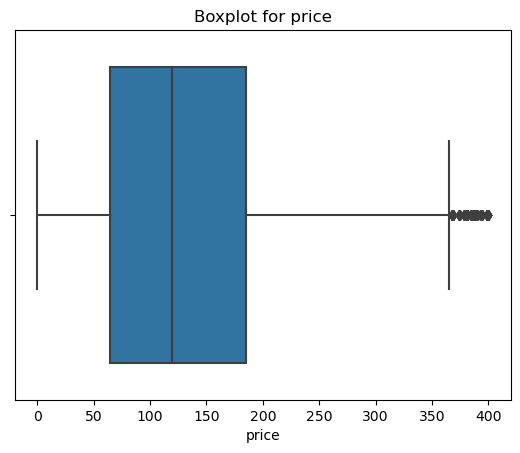

NY
Before: 48895, After: 45923


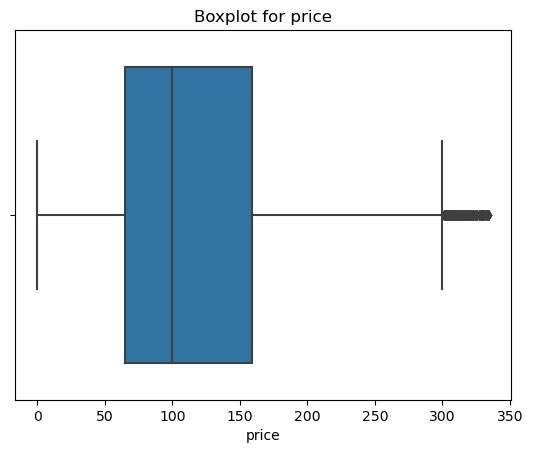

Madrid
Before: 19618, After: 17713


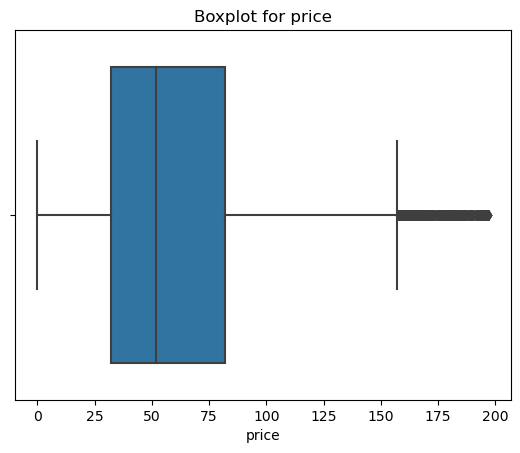

In [92]:
print("Singapore")
print(f"Before: {singapore_df.shape[0]}, After: {singapore_drop_target_outliers.shape[0]}")
print_outliers(singapore_drop_target_outliers, ['price'])

print("NY")
print(f"Before: {ny_df.shape[0]}, After: {ny_drop_target_outliers.shape[0]}")
print_outliers(ny_drop_target_outliers, ['price'])


print("Madrid")
print(f"Before: {madrid_df.shape[0]}, After: {madrid_drop_target_outliers.shape[0]}")
print_outliers(madrid_drop_target_outliers, ['price'])

#### Results

In [93]:
singapore_rf_rmse, singapore_rf_mae, singapore_rf_r2 = calculate_metrics(singapore_y_test_impv2, get_prediction(singapore_X_train_impv2, singapore_y_train_impv2, singapore_X_test_impv2, rf_model))
singapore_lr_rmse, singapore_lr_mae, singapore_lr_r2 = calculate_metrics(singapore_y_test_impv2, get_prediction(singapore_X_train_impv2, singapore_y_train_impv2, singapore_X_test_impv2, lr_model))
singapore_xg_rmse, singapore_xg_mae, singapore_xg_r2 = calculate_metrics(singapore_y_test_impv2, get_prediction(singapore_X_train_impv2, singapore_y_train_impv2, singapore_X_test_impv2, xg_model))


# Singapore
print("Singapore:")
print(f"Random Forest Regressor: RSME: {singapore_rf_rmse}, MAE: {singapore_rf_mae}, R2: {singapore_rf_r2}")
print(f"Linear Regression: RSME: {singapore_lr_rmse}, MAE: {singapore_lr_mae}, R2: {singapore_lr_r2}")
print(f"XGBoost: RSME: {singapore_xg_rmse}, MAE: {singapore_xg_mae}, R2: {singapore_xg_r2}")


# NY
ny_rf_rmse, ny_rf_mae, ny_rf_r2 = calculate_metrics(ny_y_test_impv2, get_prediction(ny_X_train_impv2, ny_y_train_impv2, ny_X_test_impv2, rf_model))
ny_lr_rmse, ny_lr_mae, ny_lr_r2 = calculate_metrics(ny_y_test_impv2, get_prediction(ny_X_train_impv2, ny_y_train_impv2, ny_X_test_impv2, lr_model))
ny_xg_rmse, ny_xg_mae, ny_xg_r2 = calculate_metrics(ny_y_test_impv2, get_prediction(ny_X_train_impv2, ny_y_train_impv2, ny_X_test_impv2, xg_model))

print("\nNY:")
print(f"Random Forest Regressor: RSME: {ny_rf_rmse}, MAE: {ny_rf_mae}, R2: {ny_rf_r2}")
print(f"Linear Regression: RSME: {ny_lr_rmse}, MAE: {ny_lr_mae}, R2: {ny_lr_r2}")
print(f"XGBoost: RSME: {ny_xg_rmse}, MAE: {ny_xg_mae}, R2: {ny_xg_r2}")


# Madrid
madrid_rf_rmse, madrid_rf_mae, madrid_rf_r2 = calculate_metrics(madrid_y_test_impv2, get_prediction(madrid_X_train_impv2, madrid_y_train_impv2, madrid_X_test_impv2, rf_model))
madrid_lr_rmse, madrid_lr_mae, madrid_lr_r2 = calculate_metrics(madrid_y_test_impv2, get_prediction(madrid_X_train_impv2, madrid_y_train_impv2, madrid_X_test_impv2, lr_model)) 
madrid_xg_rmse, madrid_xg_mae, madrid_xg_r2 = calculate_metrics(madrid_y_test_impv2, get_prediction(madrid_X_train_impv2, madrid_y_train_impv2, madrid_X_test_impv2, xg_model))

print("\nMadrid:")
print(f"Random Forest Regressor: RSME: {madrid_rf_rmse}, MAE: {madrid_rf_mae}, R2: {madrid_rf_r2}")
print(f"Linear Regression: RSME: {madrid_lr_rmse}, MAE: {madrid_lr_mae}, R2: {madrid_lr_r2}")
print(f"XGBoost: RSME: {madrid_xg_rmse}, MAE: {madrid_xg_mae}, R2: {madrid_xg_r2}")

Singapore:
Random Forest Regressor: RSME: 48.78025478579456, MAE: 33.43250109890109, R2: 0.6714393629065607
Linear Regression: RSME: 62.37600990525254, MAE: 47.74120422563137, R2: 0.46276712139376897
XGBoost: RSME: 52.33028746303619, MAE: 36.04482948403437, R2: 0.6218765218272317

NY:
Random Forest Regressor: RSME: 45.1718127069369, MAE: 32.230603179211734, R2: 0.5593908757611763
Linear Regression: RSME: 47.340703938088964, MAE: 34.54731641628165, R2: 0.5160640655188609
XGBoost: RSME: 44.440147096919326, MAE: 31.85080621376987, R2: 0.5735487179417215

Madrid:
Random Forest Regressor: RSME: 29.221823065166777, MAE: 20.605178584870153, R2: 0.4540244030874403
Linear Regression: RSME: 31.83106885283368, MAE: 23.176858894473735, R2: 0.3521699902955431
XGBoost: RSME: 29.47115207234667, MAE: 20.98490497399238, R2: 0.4446678141466156


### Furthur Improvements on Removing Price Outliers
Outliers present in other numeric features as visualized in the EDA may be influencing price prediction\
Such features are 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365'\

Strategies:
- Outlier Capping
- Log Transformation
- Outlier Removal

In [94]:
numeric_features = ['minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']

### Outlier Capping

In [95]:
# 1. Outlier Capping
def cap_outliers(df):
    transformed_df = df.copy()
    for feature in numeric_features:
        Q1 = transformed_df[feature].quantile(0.25)
        Q3 = transformed_df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        transformed_df.loc[transformed_df[feature] < lower_bound, feature] = lower_bound
        transformed_df.loc[transformed_df[feature] > upper_bound, feature] = upper_bound
    return transformed_df

singapore_df_capped = cap_outliers(singapore_df)
ny_df_capped = cap_outliers(ny_df)
madrid_df_capped = cap_outliers(madrid_df)


singapore_X_capped, singapore_y_capped = get_X_y(drop_target_oultiers(singapore_df_capped))
ny_X_capped, ny_y_capped = get_X_y(drop_target_oultiers(ny_df_capped))
madrid_X_capped, madrid_y_capped = get_X_y(drop_target_oultiers(madrid_df_capped))

# Split the data into training and testing sets
singapore_X_train_capped, singapore_X_test_capped, singapore_y_train_capped, singapore_y_test_capped = train_test_split(singapore_X_capped, singapore_y_capped, test_size=0.3, random_state=42)
ny_X_train_capped, ny_X_test_capped, ny_y_train_capped, ny_y_test_capped = train_test_split(ny_X_capped, ny_y_capped, test_size=0.3, random_state=42)
madrid_X_train_capped, madrid_X_test_capped, madrid_y_train_capped, madrid_y_test_capped = train_test_split(madrid_X_capped, madrid_y_capped, test_size=0.3, random_state=42)

#### Outliers Visual After Capping

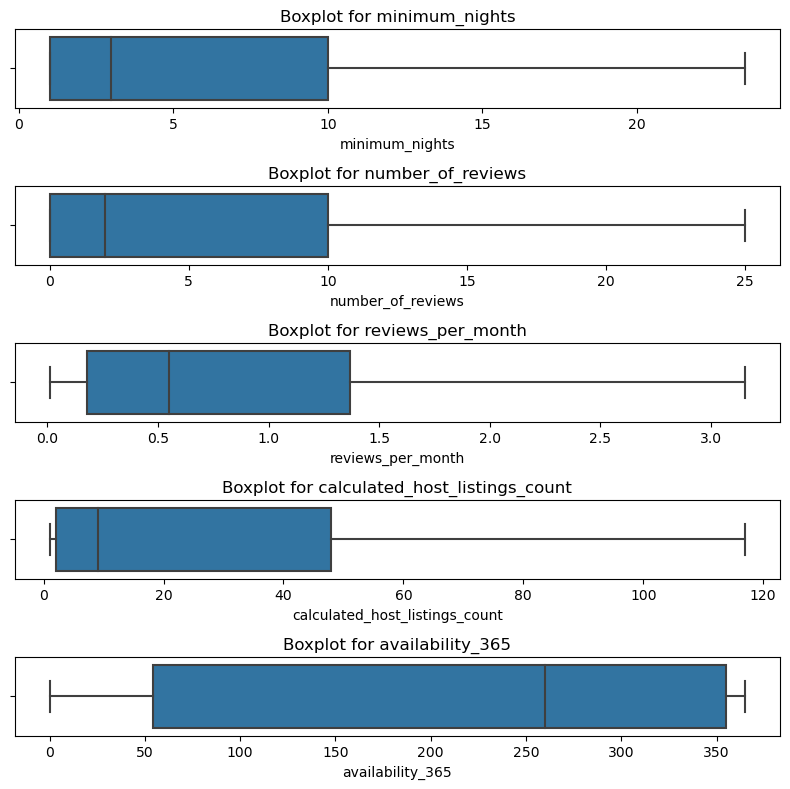

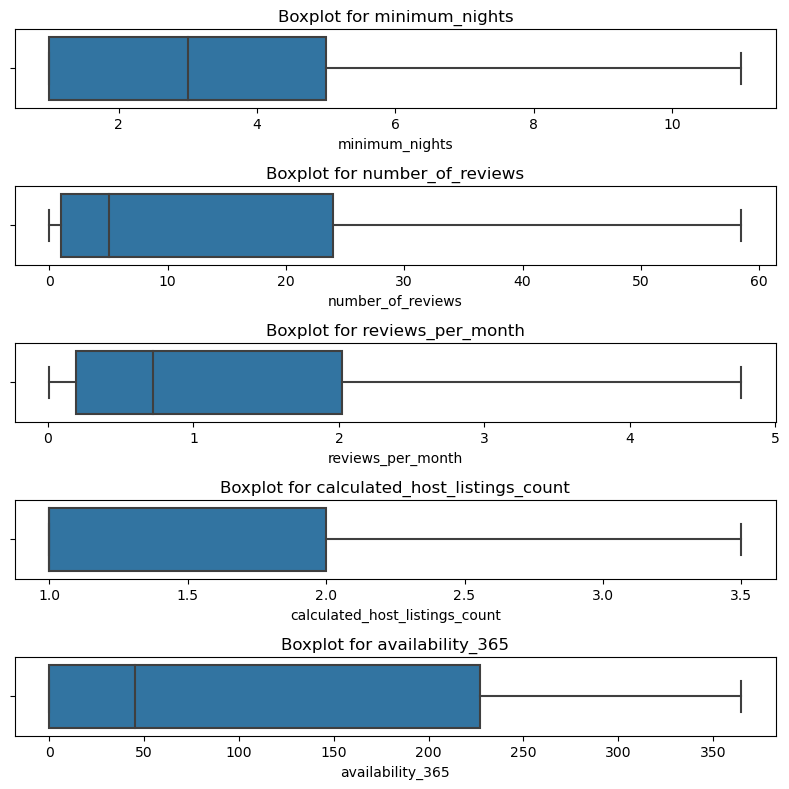

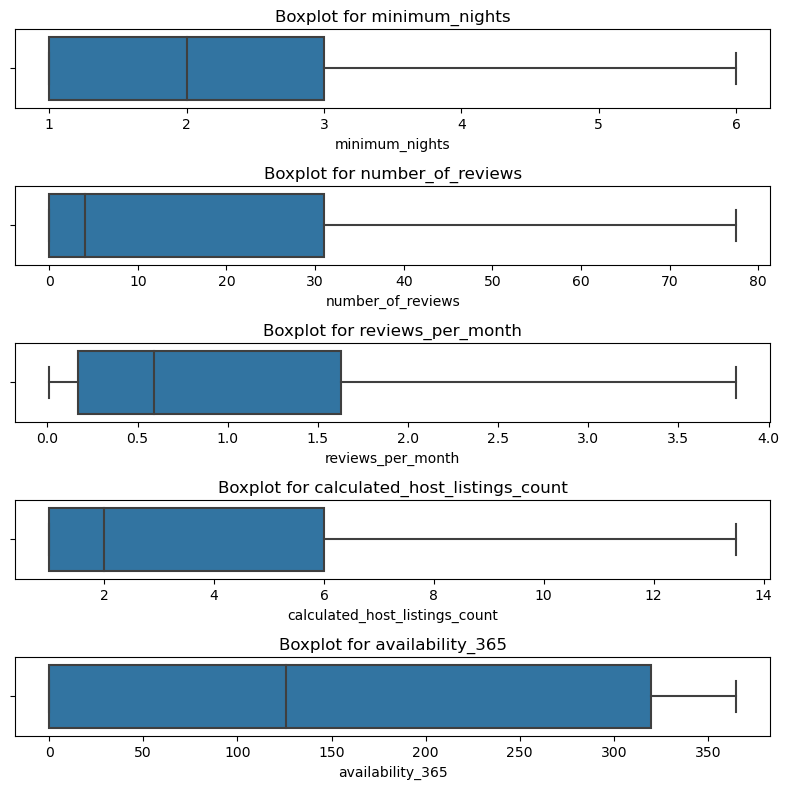

In [96]:
print_outliers(singapore_df_capped, numeric_features)
print_outliers(ny_df_capped, numeric_features)
print_outliers(madrid_df_capped, numeric_features)

#### Results

In [97]:
rmse_rf, mae_rf, r2_rf = calculate_metrics(singapore_y_test_capped, get_prediction(singapore_X_train_capped, singapore_y_train_capped, singapore_X_test_capped, rf_model))
rmse_lr, mae_lr, r2_lr = calculate_metrics(singapore_y_test_capped, get_prediction(singapore_X_train_capped, singapore_y_train_capped, singapore_X_test_capped, lr_model))
rmse_xg, mae_xg, r2_xg = calculate_metrics(singapore_y_test_capped, get_prediction(singapore_X_train_capped, singapore_y_train_capped, singapore_X_test_capped, xg_model))

print("Singapore:")
print(f"Random Forest Regressor: RSME: {rmse_rf}, MAE: {mae_rf}, R2: {r2_rf}")
print(f"Linear Regression: RSME: {rmse_lr}, MAE: {mae_lr}, R2: {r2_lr}")
print(f"XGBoost: RSME: {rmse_xg}, MAE: {mae_xg}, R2: {r2_xg}")

rmse_rf, mae_rf, r2_rf = calculate_metrics(ny_y_test_capped, get_prediction(ny_X_train_capped, ny_y_train_capped, ny_X_test_capped, rf_model))
rmse_lr, mae_lr, r2_lr = calculate_metrics(ny_y_test_capped, get_prediction(ny_X_train_capped, ny_y_train_capped, ny_X_test_capped, lr_model))
rmse_xg, mae_xg, r2_xg = calculate_metrics(ny_y_test_capped, get_prediction(ny_X_train_capped, ny_y_train_capped, ny_X_test_capped, xg_model))

print("\nNY:")
print(f"Random Forest Regressor: RSME: {rmse_rf}, MAE: {mae_rf}, R2: {r2_rf}")
print(f"Linear Regression: RSME: {rmse_lr}, MAE: {mae_lr}, R2: {r2_lr}")
print(f"XGBoost: RSME: {rmse_xg}, MAE: {mae_xg}, R2: {r2_xg}")

rmse_rf, mae_rf, r2_rf = calculate_metrics(madrid_y_test_capped, get_prediction(madrid_X_train_capped, madrid_y_train_capped, madrid_X_test_capped, rf_model))
rmse_lr, mae_lr, r2_lr = calculate_metrics(madrid_y_test_capped, get_prediction(madrid_X_train_capped, madrid_y_train_capped, madrid_X_test_capped, lr_model))
rmse_xg, mae_xg, r2_xg = calculate_metrics(madrid_y_test_capped, get_prediction(madrid_X_train_capped, madrid_y_train_capped, madrid_X_test_capped, xg_model))

print("\nMadrid:")
print(f"Random Forest Regressor: RSME: {rmse_rf}, MAE: {mae_rf}, R2: {r2_rf}")
print(f"Linear Regression: RSME: {rmse_lr}, MAE: {mae_lr}, R2: {r2_lr}")
print(f"XGBoost: RSME: {rmse_xg}, MAE: {mae_xg}, R2: {r2_xg}")

Singapore:
Random Forest Regressor: RSME: 48.722190459428596, MAE: 33.446505494505494, R2: 0.6722210848491696
Linear Regression: RSME: 61.36929311227435, MAE: 46.64861093165604, R2: 0.47996850732493
XGBoost: RSME: 51.857208783486435, MAE: 35.817328530615505, R2: 0.6286822779212311

NY:
Random Forest Regressor: RSME: 45.2828730266332, MAE: 32.41268636132685, R2: 0.5572216315997806
Linear Regression: RSME: 46.94808586732849, MAE: 34.265606406232855, R2: 0.5240577830005171
XGBoost: RSME: 44.86099166604935, MAE: 32.22721054208394, R2: 0.5654335563334476

Madrid:
Random Forest Regressor: RSME: 29.846619787329757, MAE: 21.063564412065165, R2: 0.43042761551599107
Linear Regression: RSME: 31.740365137724453, MAE: 23.100385399665086, R2: 0.35585675738219913
XGBoost: RSME: 30.57562712238208, MAE: 21.885861381669667, R2: 0.40226406610123067


### Outlier Log Transformation

In [98]:
# 2. Log Transformation
def apply_log_transformation(df):
    log_transform = FunctionTransformer(np.log1p)
    transformed_df = df.copy()
    
    for feature in numeric_features:
        transformed_df[feature] = log_transform.fit_transform(df[[feature]])
    return transformed_df

singapore_df_log = apply_log_transformation(singapore_df)
ny_df_log = apply_log_transformation(ny_df)
madrid_df_log = apply_log_transformation(madrid_df)

singapore_X_log, singapore_y_log = get_X_y(drop_target_oultiers(singapore_df_log))
ny_X_log, ny_y_log = get_X_y(drop_target_oultiers(ny_df_log))
madrid_X_log, madrid_y_log = get_X_y(drop_target_oultiers(madrid_df_log))

# Split the data into training and testing sets
singapore_X_train_log, singapore_X_test_log, singapore_y_train_log, singapore_y_test_log = train_test_split(singapore_X_log, singapore_y_log, test_size=0.3, random_state=42)
ny_X_train_log, ny_X_test_log, ny_y_train_log, ny_y_test_log = train_test_split(ny_X_log, ny_y_log, test_size=0.3, random_state=42)
madrid_X_train_log, madrid_X_test_log, madrid_y_train_log, madrid_y_test_log = train_test_split(madrid_X_log, madrid_y_log, test_size=0.3, random_state=42)


#### Outlier Visual After Log Transformation

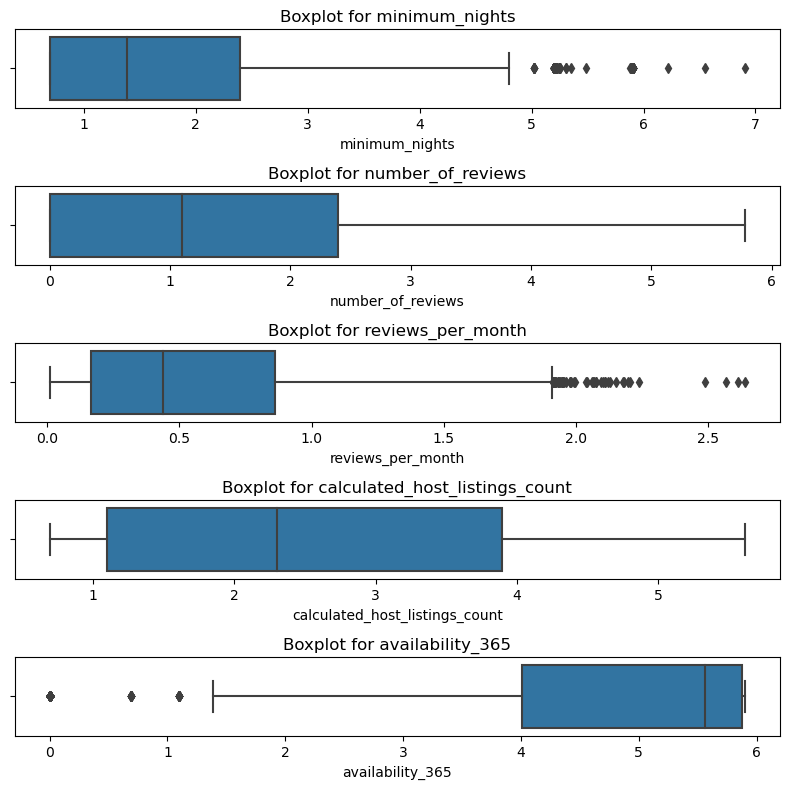

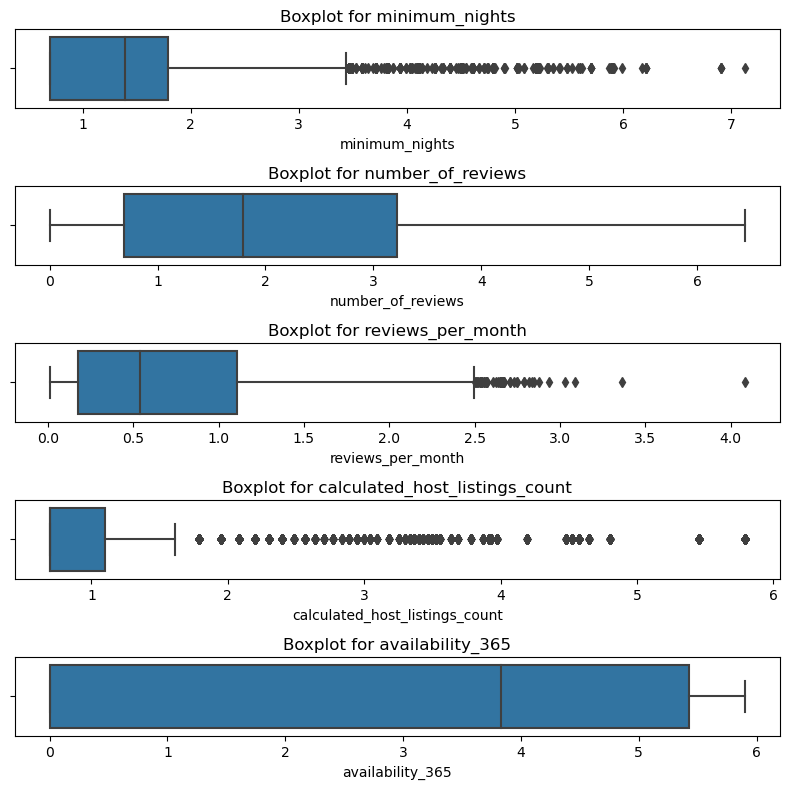

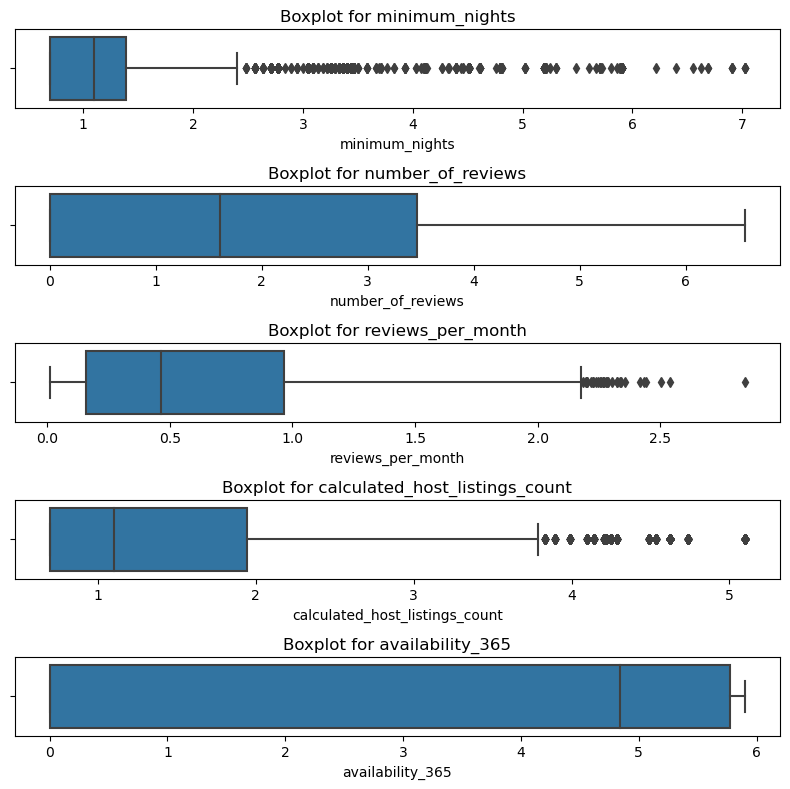

In [99]:
print_outliers(singapore_df_log, numeric_features)
print_outliers(ny_df_log, numeric_features)
print_outliers(madrid_df_log, numeric_features)

#### Results

In [100]:
rmse_rf, mae_rf, r2_rf = calculate_metrics(singapore_y_test_log, get_prediction(singapore_X_train_log, singapore_y_train_log, singapore_X_test_log, rf_model))
rmse_lr, mae_lr, r2_lr = calculate_metrics(singapore_y_test_log, get_prediction(singapore_X_train_log, singapore_y_train_log, singapore_X_test_log, lr_model))
rmse_xg, mae_xg, r2_xg = calculate_metrics(singapore_y_test_log, get_prediction(singapore_X_train_log, singapore_y_train_log, singapore_X_test_log, xg_model))

print("Singapore:")
print(f"Random Forest Regressor: RSME: {rmse_rf}, MAE: {mae_rf}, R2: {r2_rf}")
print(f"Linear Regression: RSME: {rmse_lr}, MAE: {mae_lr}, R2: {r2_lr}")
print(f"XGBoost: RSME: {rmse_xg}, MAE: {mae_xg}, R2: {r2_xg}")

rmse_rf, mae_rf, r2_rf = calculate_metrics(ny_y_test_log, get_prediction(ny_X_train_log, ny_y_train_log, ny_X_test_log, rf_model))
rmse_lr, mae_lr, r2_lr = calculate_metrics(ny_y_test_log, get_prediction(ny_X_train_log, ny_y_train_log, ny_X_test_log, lr_model))
rmse_xg, mae_xg, r2_xg = calculate_metrics(ny_y_test_log, get_prediction(ny_X_train_log, ny_y_train_log, ny_X_test_log, xg_model))

print("\nNY:")
print(f"Random Forest Regressor: RSME: {rmse_rf}, MAE: {mae_rf}, R2: {r2_rf}")
print(f"Linear Regression: RSME: {rmse_lr}, MAE: {mae_lr}, R2: {r2_lr}")
print(f"XGBoost: RSME: {rmse_xg}, MAE: {mae_xg}, R2: {r2_xg}")

rmse_rf, mae_rf, r2_rf = calculate_metrics(madrid_y_test_log, get_prediction(madrid_X_train_log, madrid_y_train_log, madrid_X_test_log, rf_model))
rmse_lr, mae_lr, r2_lr = calculate_metrics(madrid_y_test_log, get_prediction(madrid_X_train_log, madrid_y_train_log, madrid_X_test_log, lr_model))
rmse_xg, mae_xg, r2_xg = calculate_metrics(madrid_y_test_log, get_prediction(madrid_X_train_log, madrid_y_train_log, madrid_X_test_log, xg_model))

print("\nMadrid:")
print(f"Random Forest Regressor: RSME: {rmse_rf}, MAE: {mae_rf}, R2: {r2_rf}")
print(f"Linear Regression: RSME: {rmse_lr}, MAE: {mae_lr}, R2: {r2_lr}")
print(f"XGBoost: RSME: {rmse_xg}, MAE: {mae_xg}, R2: {r2_xg}")

Singapore:
Random Forest Regressor: RSME: 48.753877577656766, MAE: 33.351775824175824, R2: 0.6717945955392628
Linear Regression: RSME: 61.567861832865994, MAE: 46.80792165868, R2: 0.4765977972499712
XGBoost: RSME: 52.33028746303619, MAE: 36.04482948403437, R2: 0.6218765218272317

NY:
Random Forest Regressor: RSME: 45.14059223659279, MAE: 32.20036123006944, R2: 0.559999718733766
Linear Regression: RSME: 46.67747816104808, MAE: 34.14749109557632, R2: 0.5295286109373816
XGBoost: RSME: 44.440147096919326, MAE: 31.85080621376987, R2: 0.5735487179417215

Madrid:
Random Forest Regressor: RSME: 29.205348478193933, MAE: 20.598029011416386, R2: 0.45463984634217813
Linear Regression: RSME: 31.726242322377253, MAE: 23.125910953665144, R2: 0.35642985048688713
XGBoost: RSME: 29.47115207234667, MAE: 20.98490497399238, R2: 0.4446678141466156


### Outlier Removal

In [101]:
numeric_features = [
            'minimum_nights', 'number_of_reviews', 
            'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'price'
        ]
# 3. Outlier Removal
def remove_outliers(df):
    transformed_df = df.copy()
    for feature in numeric_features:
        Q1 = transformed_df[feature].quantile(0.25)
        Q3 = transformed_df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        transformed_df = transformed_df[(transformed_df[feature] >= lower_bound) & (transformed_df[feature] <= upper_bound)]
    return transformed_df

singapore_df_no_outliers = remove_outliers(singapore_df)
ny_df_no_outliers = remove_outliers(ny_df)
madrid_df_no_outliers = remove_outliers(madrid_df)

singapore_X_no_outliers, singapore_y_no_outliers = get_X_y(singapore_df_no_outliers)
ny_X_no_outliers, ny_y_no_outliers = get_X_y(ny_df_no_outliers)
madrid_X_no_outliers, madrid_y_no_outliers = get_X_y(madrid_df_no_outliers)

# Split the data into training and testing sets
singapore_X_train_no_outliers, singapore_X_test_no_outliers, singapore_y_train_no_outliers, singapore_y_test_no_outliers = train_test_split(singapore_X_no_outliers, singapore_y_no_outliers, test_size=0.3, random_state=42)
ny_X_train_no_outliers, ny_X_test_no_outliers, ny_y_train_no_outliers, ny_y_test_no_outliers = train_test_split(ny_X_no_outliers, ny_y_no_outliers, test_size=0.3, random_state=42)
madrid_X_train_no_outliers, madrid_X_test_no_outliers, madrid_y_train_no_outliers, madrid_y_test_no_outliers = train_test_split(madrid_X_no_outliers, madrid_y_no_outliers, test_size=0.3, random_state=42)

#### Outlier Visual After Removal

Singapore
Before: 7907, After: 2646
NY
Before: 48895, After: 22366
Madrid
Before: 19618, After: 7828


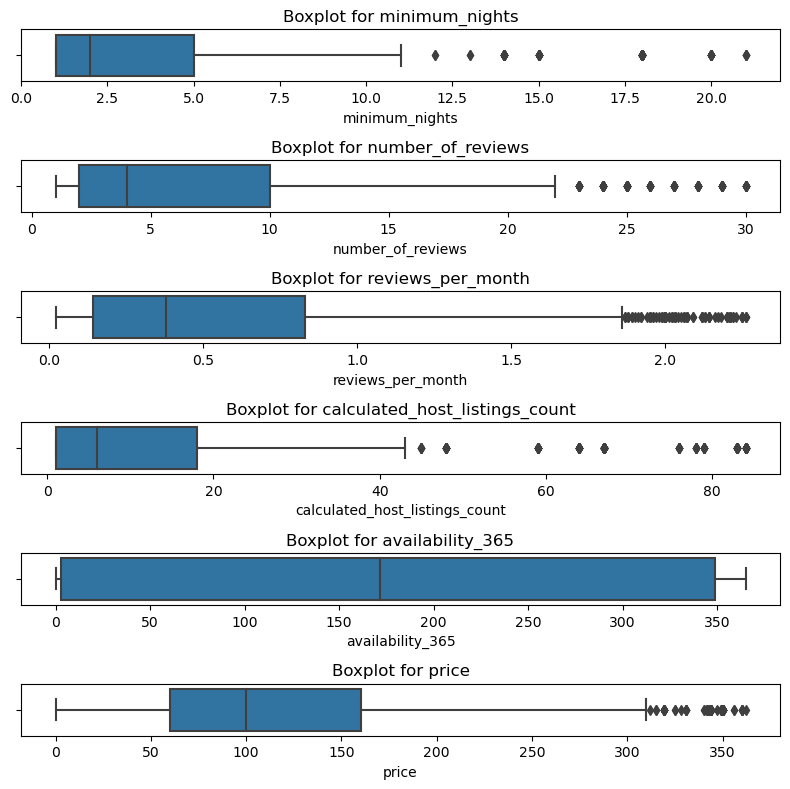

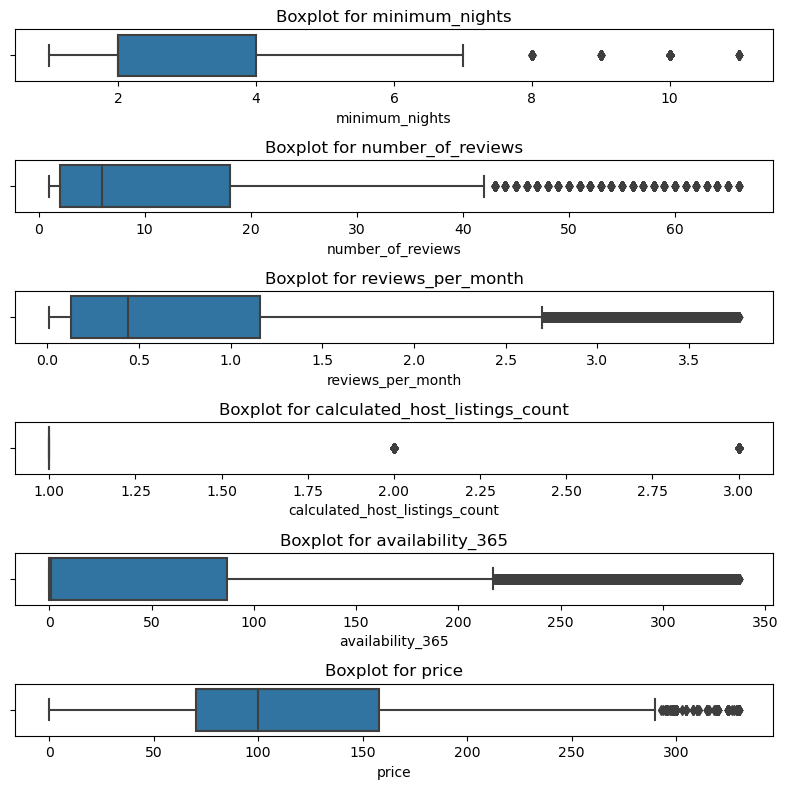

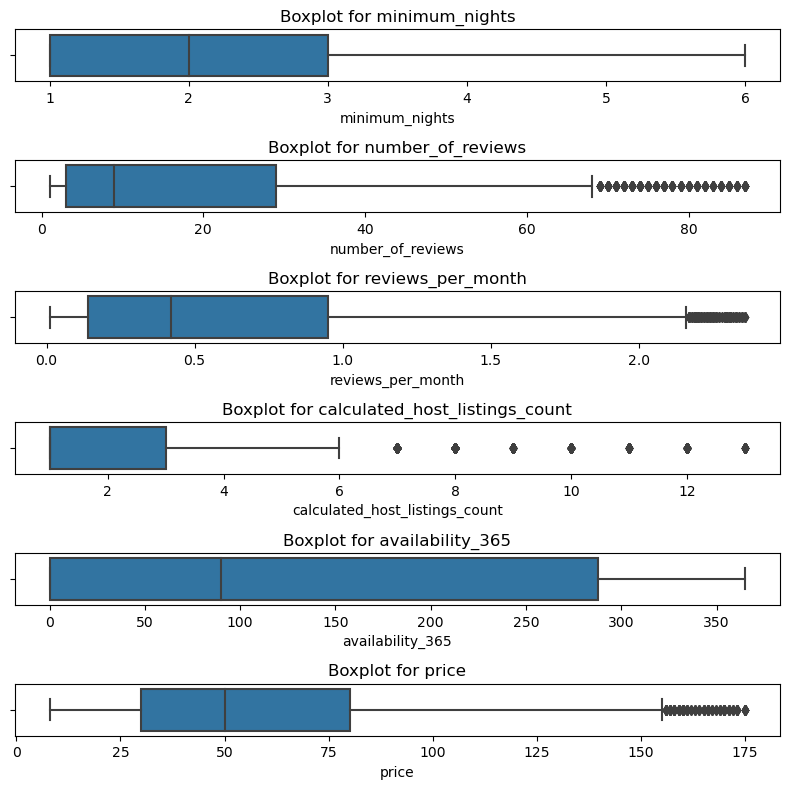

In [102]:
print("Singapore")
print(f"Before: {singapore_df.shape[0]}, After: {singapore_df_no_outliers.shape[0]}")
print_outliers(singapore_df_no_outliers, numeric_features)

print("NY")
print(f"Before: {ny_df.shape[0]}, After: {ny_df_no_outliers.shape[0]}")
print_outliers(ny_df_no_outliers, numeric_features)

print("Madrid")
print(f"Before: {madrid_df.shape[0]}, After: {madrid_df_no_outliers.shape[0]}")
print_outliers(madrid_df_no_outliers, numeric_features)

#### Results

In [103]:
rmse_rf, mae_rf, r2_rf = calculate_metrics(singapore_y_test_no_outliers, get_prediction(singapore_X_train_no_outliers, singapore_y_train_no_outliers, singapore_X_test_no_outliers, rf_model))
rmse_lr, mae_lr, r2_lr = calculate_metrics(singapore_y_test_no_outliers, get_prediction(singapore_X_train_no_outliers, singapore_y_train_no_outliers, singapore_X_test_no_outliers, lr_model))
rmse_xg, mae_xg, r2_xg = calculate_metrics(singapore_y_test_no_outliers, get_prediction(singapore_X_train_no_outliers, singapore_y_train_no_outliers, singapore_X_test_no_outliers, xg_model))

print("Singapore:")
print(f"Random Forest Regressor: RSME: {rmse_rf}, MAE: {mae_rf}, R2: {r2_rf}")
print(f"Linear Regression: RSME: {rmse_lr}, MAE: {mae_lr}, R2: {r2_lr}")
print(f"XGBoost: RSME: {rmse_xg}, MAE: {mae_xg}, R2: {r2_xg}")

rmse_rf, mae_rf, r2_rf = calculate_metrics(ny_y_test_no_outliers, get_prediction(ny_X_train_no_outliers, ny_y_train_no_outliers, ny_X_test_no_outliers, rf_model))
rmse_lr, mae_lr, r2_lr = calculate_metrics(ny_y_test_no_outliers, get_prediction(ny_X_train_no_outliers, ny_y_train_no_outliers, ny_X_test_no_outliers, lr_model))
rmse_xg, mae_xg, r2_xg = calculate_metrics(ny_y_test_no_outliers, get_prediction(ny_X_train_no_outliers, ny_y_train_no_outliers, ny_X_test_no_outliers, xg_model))

print("\nNY:")
print(f"Random Forest Regressor: RSME: {rmse_rf}, MAE: {mae_rf}, R2: {r2_rf}")
print(f"Linear Regression: RSME: {rmse_lr}, MAE: {mae_lr}, R2: {r2_lr}")
print(f"XGBoost: RSME: {rmse_xg}, MAE: {mae_xg}, R2: {r2_xg}")

rmse_rf, mae_rf, r2_rf = calculate_metrics(madrid_y_test_no_outliers, get_prediction(madrid_X_train_no_outliers, madrid_y_train_no_outliers, madrid_X_test_no_outliers, rf_model))
rmse_lr, mae_lr, r2_lr = calculate_metrics(madrid_y_test_no_outliers, get_prediction(madrid_X_train_no_outliers, madrid_y_train_no_outliers, madrid_X_test_no_outliers, lr_model))
rmse_xg, mae_xg, r2_xg = calculate_metrics(madrid_y_test_no_outliers, get_prediction(madrid_X_train_no_outliers, madrid_y_train_no_outliers, madrid_X_test_no_outliers, xg_model))

print("\nMadrid:")
print(f"Random Forest Regressor: RSME: {rmse_rf}, MAE: {mae_rf}, R2: {r2_rf}")
print(f"Linear Regression: RSME: {rmse_lr}, MAE: {mae_lr}, R2: {r2_lr}")
print(f"XGBoost: RSME: {rmse_xg}, MAE: {mae_xg}, R2: {r2_xg}")


Singapore:
Random Forest Regressor: RSME: 49.187517299213766, MAE: 32.739609571788414, R2: 0.6129882975511777
Linear Regression: RSME: 56.146499697784, MAE: 40.98300428070697, R2: 0.4957340248471257
XGBoost: RSME: 52.435168730640854, MAE: 36.757450891682126, R2: 0.5601955369096767

NY:
Random Forest Regressor: RSME: 45.11052012217322, MAE: 32.87091803278689, R2: 0.5299185966674935
Linear Regression: RSME: 45.23312169565673, MAE: 33.305642420145354, R2: 0.5273599457457401
XGBoost: RSME: 44.82695339181658, MAE: 32.59396505398473, R2: 0.5358099268081282

Madrid:
Random Forest Regressor: RSME: 26.389481154878162, MAE: 19.036687952320136, R2: 0.47115477152751106
Linear Regression: RSME: 27.146367581692413, MAE: 19.84196408598373, R2: 0.4403837229124016
XGBoost: RSME: 27.23933011921054, MAE: 19.581103520628847, R2: 0.43654435650087


### HyperParameter Tuning using Randomized Search CV

In [104]:
# Define hyperparameters for each model
rf_params = {
    'model__n_estimators': [int(x) for x in np.linspace(100, 1000, num=20)],
    'model__max_features': ['log2', 'sqrt'],
    'model__max_depth': [int(x) for x in np.linspace(10, 150, num=11)],
    'model__min_samples_split': [2, 5, 10, 20],
    'model__min_samples_leaf': [1, 2, 4, 10],
    'model__bootstrap': [True, False],
}

lr_params = {
    'model__fit_intercept': [True, False],
}

xgb_params = {
    'model__learning_rate': [0.05, 0.1, 0.15, 0.2],
    'model__n_estimators': [100, 200, 300, 400, 500],
    'model__max_depth': [3, 4, 5, 6],
    'model__subsample': [0.7, 0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.5, 0.6, 0.7, 0.8],
    'model__reg_alpha': [0, 0.1, 0.2, 0.3, 0.5],
    'model__reg_lambda': [0, 0.1, 0.2, 0.3, 0.5],
    'model__gamma': [0, 1, 2],
}

# Perform hyperparameter search with the subsets
def get_hyperparameter_search(model, params):
    rnd_search_cv = RandomizedSearchCV(
        model, params, cv=3, n_iter=10, random_state=42, n_jobs=1, scoring='neg_mean_squared_error'
    )
    # rnd_search_cv.fit(X_train, y_train)
    return rnd_search_cv

rf_search_model = get_hyperparameter_search(rf_model, rf_params)
lr_search_model = get_hyperparameter_search(lr_model, lr_params)
xgb_search_model = get_hyperparameter_search(xg_model, xgb_params)

def get_prediction_cv(X_train, y_train, X_test, model):
    model.fit(X_train, y_train)    
    best_model = model.best_estimator_
    y_pred = best_model.predict(X_test)
    return y_pred


##### Improved Preprocessing V2 (Price Outlier Removal)

In [105]:
singapore_X_improvedv2, singapore_y_improvedv2 = get_X_y(singapore_drop_target_outliers)
ny_X_improvedv2, ny_y_improvedv2 = get_X_y(ny_drop_target_outliers)
madrid_X_improvedv2, madrid_y_improvedv2 = get_X_y(madrid_drop_target_outliers)

# Split the data into training and testing sets
singapore_X_train_impv2, singapore_X_test_impv2, singapore_y_train_impv2, singapore_y_test_impv2 = train_test_split(singapore_X_improvedv2, singapore_y_improvedv2, test_size=0.3, random_state=42)
ny_X_train_impv2, ny_X_test_impv2, ny_y_train_impv2, ny_y_test_impv2 = train_test_split(ny_X_improvedv2, ny_y_improvedv2, test_size=0.3, random_state=42)
madrid_X_train_impv2, madrid_X_test_impv2, madrid_y_train_impv2, madrid_y_test_impv2 = train_test_split(madrid_X_improvedv2, madrid_y_improvedv2, test_size=0.3, random_state=42)

In [106]:
# Calculate metrics for each city
# Singapore
singapore_rf_rmse, singapore_rf_mae, singapore_rf_r2 = calculate_metrics(singapore_y_test_impv2, get_prediction_cv(singapore_X_train_impv2, singapore_y_train_impv2, singapore_X_test_impv2, rf_search_model))
singapore_lr_rmse, singapore_lr_mae, singapore_lr_r2 = calculate_metrics(singapore_y_test_impv2, get_prediction_cv(singapore_X_train_impv2, singapore_y_train_impv2, singapore_X_test_impv2, lr_search_model))
singapore_xgb_rmse, singapore_xgb_mae, singapore_xgb_r2 = calculate_metrics(singapore_y_test_impv2, get_prediction_cv(singapore_X_train_impv2, singapore_y_train_impv2, singapore_X_test_impv2, xgb_search_model))

print("Singapore")
print(f'Random Forest Regressor RMSE: {singapore_rf_rmse}, MAE: {singapore_rf_mae}', f'R2: {singapore_rf_r2}')
print(f'Linear Regression RMSE: {singapore_lr_rmse}, MAE: {singapore_lr_mae}', f'R2: {singapore_lr_r2}')
print(f'XGBoost RMSE: {singapore_xgb_rmse}, MAE: {singapore_xgb_mae}', f'R2: {singapore_xgb_r2}')


# New York
ny_rf_rmse, ny_rf_mae, ny_rf_r2 = calculate_metrics(ny_y_test_impv2, get_prediction_cv(ny_X_train_impv2, ny_y_train_impv2, ny_X_test_impv2, rf_search_model))
ny_lr_rmse, ny_lr_mae, ny_lr_r2 = calculate_metrics(ny_y_test_impv2, get_prediction_cv(ny_X_train_impv2, ny_y_train_impv2, ny_X_test_impv2, lr_search_model))
ny_xgb_rmse, ny_xgb_mae, ny_xgb_r2 = calculate_metrics(ny_y_test_impv2, get_prediction_cv(ny_X_train_impv2, ny_y_train_impv2, ny_X_test_impv2, xgb_search_model))

print("\nNew York")
print(f'Random Forest Regressor RMSE: {ny_rf_rmse}, MAE: {ny_rf_mae}', f'R2: {ny_rf_r2}')
print(f'Linear Regression RMSE: {ny_lr_rmse}, MAE: {ny_lr_mae}', f'R2: {ny_lr_r2}')
print(f'XGBoost RMSE: {ny_xgb_rmse}, MAE: {ny_xgb_mae}', f'R2: {ny_xgb_r2}')


# Madrid
madrid_rf_rmse, madrid_rf_mae, madrid_rf_r2 = calculate_metrics(madrid_y_test_impv2, get_prediction_cv(madrid_X_train_impv2, madrid_y_train_impv2, madrid_X_test_impv2, rf_search_model))
madrid_lr_rmse, madrid_lr_mae, madrid_lr_r2 = calculate_metrics(madrid_y_test_impv2, get_prediction_cv(madrid_X_train_impv2, madrid_y_train_impv2, madrid_X_test_impv2, lr_search_model))
madrid_xgb_rmse, madrid_xgb_mae, madrid_xgb_r2 = calculate_metrics(madrid_y_test_impv2, get_prediction_cv(madrid_X_train_impv2, madrid_y_train_impv2, madrid_X_test_impv2, xgb_search_model))

print("\nMadrid")
print(f'Random Forest Regressor RMSE: {madrid_rf_rmse}, MAE: {madrid_rf_mae}', f'R2: {madrid_rf_r2}')
print(f'Linear Regression RMSE: {madrid_lr_rmse}, MAE: {madrid_lr_mae}', f'R2: {madrid_lr_r2}')
print(f'XGBoost RMSE: {madrid_xgb_rmse}, MAE: {madrid_xgb_mae}', f'R2: {madrid_xgb_r2}')

Singapore
Random Forest Regressor RMSE: 48.9747565572672, MAE: 34.13523081977845 R2: 0.6688139960709609
Linear Regression RMSE: 62.37469737086637, MAE: 47.73897297764333 R2: 0.4627897303810631
XGBoost RMSE: 51.11195848858659, MAE: 35.918112588609965 R2: 0.639278151312916

New York
Random Forest Regressor RMSE: 44.38099727377039, MAE: 31.861399621744177 R2: 0.5746831755278912
Linear Regression RMSE: 47.34106416035974, MAE: 34.547697967627435 R2: 0.5160567008136512
XGBoost RMSE: 44.25062743069074, MAE: 31.758534272108005 R2: 0.5771782545340356

Madrid
Random Forest Regressor RMSE: 28.98099170728022, MAE: 20.64606061359219 R2: 0.4629866239177062
Linear Regression RMSE: 31.830699322029886, MAE: 23.17683368846895 R2: 0.352185031685183
XGBoost RMSE: 29.39974336717465, MAE: 21.193685745537888 R2: 0.4473556975020737


### Outlier Removal for both price and numberic features

In [107]:
singapore_X_no_outliers, singapore_y_no_outliers = get_X_y(singapore_df_no_outliers)
ny_X_no_outliers, ny_y_no_outliers = get_X_y(ny_df_no_outliers)
madrid_X_no_outliers, madrid_y_no_outliers = get_X_y(madrid_df_no_outliers)

# Split the data into training and testing sets
singapore_X_train_no_outliers, singapore_X_test_no_outliers, singapore_y_train_no_outliers, singapore_y_test_no_outliers = train_test_split(singapore_X_no_outliers, singapore_y_no_outliers, test_size=0.3, random_state=42)
ny_X_train_no_outliers, ny_X_test_no_outliers, ny_y_train_no_outliers, ny_y_test_no_outliers = train_test_split(ny_X_no_outliers, ny_y_no_outliers, test_size=0.3, random_state=42)
madrid_X_train_no_outliers, madrid_X_test_no_outliers, madrid_y_train_no_outliers, madrid_y_test_no_outliers = train_test_split(madrid_X_no_outliers, madrid_y_no_outliers, test_size=0.3, random_state=42)

In [108]:
rmse_rf, mae_rf, r2_rf = calculate_metrics(singapore_y_test_no_outliers, get_prediction_cv(singapore_X_train_no_outliers, singapore_y_train_no_outliers, singapore_X_test_no_outliers, rf_search_model))
rmse_lr, mae_lr, r2_lr = calculate_metrics(singapore_y_test_no_outliers, get_prediction_cv(singapore_X_train_no_outliers, singapore_y_train_no_outliers, singapore_X_test_no_outliers, lr_search_model))
rmse_xg, mae_xg, r2_xg = calculate_metrics(singapore_y_test_no_outliers, get_prediction_cv(singapore_X_train_no_outliers, singapore_y_train_no_outliers, singapore_X_test_no_outliers, xgb_search_model))

print("Singapore:")
print(f"Random Forest Regressor: RSME: {rmse_rf}, MAE: {mae_rf}, R2: {r2_rf}")
print(f"Linear Regression: RSME: {rmse_lr}, MAE: {mae_lr}, R2: {r2_lr}")
print(f"XGBoost: RSME: {rmse_xg}, MAE: {mae_xg}, R2: {r2_xg}")

rmse_rf, mae_rf, r2_rf = calculate_metrics(ny_y_test_no_outliers, get_prediction_cv(ny_X_train_no_outliers, ny_y_train_no_outliers, ny_X_test_no_outliers, rf_search_model))
rmse_lr, mae_lr, r2_lr = calculate_metrics(ny_y_test_no_outliers, get_prediction_cv(ny_X_train_no_outliers, ny_y_train_no_outliers, ny_X_test_no_outliers, lr_search_model))
rmse_xg, mae_xg, r2_xg = calculate_metrics(ny_y_test_no_outliers, get_prediction_cv(ny_X_train_no_outliers, ny_y_train_no_outliers, ny_X_test_no_outliers, xgb_search_model))

print("\nNY:")
print(f"Random Forest Regressor: RSME: {rmse_rf}, MAE: {mae_rf}, R2: {r2_rf}")
print(f"Linear Regression: RSME: {rmse_lr}, MAE: {mae_lr}, R2: {r2_lr}")
print(f"XGBoost: RSME: {rmse_xg}, MAE: {mae_xg}, R2: {r2_xg}")

rmse_rf, mae_rf, r2_rf = calculate_metrics(madrid_y_test_no_outliers, get_prediction_cv(madrid_X_train_no_outliers, madrid_y_train_no_outliers, madrid_X_test_no_outliers, rf_search_model))
rmse_lr, mae_lr, r2_lr = calculate_metrics(madrid_y_test_no_outliers, get_prediction_cv(madrid_X_train_no_outliers, madrid_y_train_no_outliers, madrid_X_test_no_outliers, lr_search_model))
rmse_xg, mae_xg, r2_xg = calculate_metrics(madrid_y_test_no_outliers, get_prediction_cv(madrid_X_train_no_outliers, madrid_y_train_no_outliers, madrid_X_test_no_outliers, xgb_search_model))

print("\nMadrid:")
print(f"Random Forest Regressor: RSME: {rmse_rf}, MAE: {mae_rf}, R2: {r2_rf}")
print(f"Linear Regression: RSME: {rmse_lr}, MAE: {mae_lr}, R2: {r2_lr}")
print(f"XGBoost: RSME: {rmse_xg}, MAE: {mae_xg}, R2: {r2_xg}")

Singapore:
Random Forest Regressor: RSME: 48.18902623812804, MAE: 33.170545642850655, R2: 0.6285412494407356
Linear Regression: RSME: 56.15475752123035, MAE: 40.98527610134557, R2: 0.4955856827193533
XGBoost: RSME: 50.364989806765465, MAE: 35.14286134945656, R2: 0.5942376068567965

NY:
Random Forest Regressor: RSME: 44.28520016599309, MAE: 32.4121691923254, R2: 0.5469620060544963
Linear Regression: RSME: 45.23297697560417, MAE: 33.305433943842345, R2: 0.5273629700952215
XGBoost: RSME: 43.976405669035906, MAE: 31.981260710714825, R2: 0.5532579199296622

Madrid:
Random Forest Regressor: RSME: 26.025114701833015, MAE: 18.975771963757374, R2: 0.48565776039191944
Linear Regression: RSME: 27.146367581692413, MAE: 19.84196408598373, R2: 0.4403837229124016
XGBoost: RSME: 26.303314407027987, MAE: 19.07585628878162, R2: 0.4746026966765019
